# Numerics of Machine Learning
## Exercise Sheet No. 2 — Scaling Gaussian Processes

---
University of Tübingen, Winter Term 2022/23
&copy; N. Bosch, J. Grosse, P. Hennig, A. Kristiadi, M. Pförtner, J. Schmidt, F. Schneider, L. Tatzel, J. Wenger, 2022 CC BY-NC-SA 3.0

In [1]:
from matplotlib import pyplot as plt
from tueplots import bundles

plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi":200})

## Solving Linear Systems with Kernel Matrices using Iterative Methods

In this first exercise we will more closely investigate the linear solve(s) $b \mapsto \hat{K}^{-1}b$ necessary for GP inference.

**Task:** Install [IterGP](https://github.com/JonathanWenger/itergp), a package for iterative Gaussian process inference from our lab:

```sh
pip uninstall probnum
git clone https://github.com/JonathanWenger/itergp
cd itergp
pip install .
```

Should you have trouble with the installation, please open an [issue on GitHub](https://github.com/JonathanWenger/itergp/issues).

In [2]:
import numpy as np
import itergp
from probnum import backend, randprocs, linops, problems, randvars

We begin by generating a synthetic dataset from a known latent function. For this sheet you can adjust the size of the dataset to your hardware.

In [3]:
# Latent function
fun = lambda x: backend.sin(x * 2 * backend.pi)

# Generate data
rng_state = backend.random.rng_state(42)

num_data = 10000
input_shape = ()
output_shape = ()

rng_state, rng_state_data = backend.random.split(rng_state, num=2)
data = itergp.datasets.SyntheticDataset(
    rng_state=rng_state,
    size=(num_data, 1000),
    input_shape=input_shape,
    output_shape=output_shape,
    noise_var=0.1,
    fun= fun
)
X = data.train.X
y = data.train.y

The [probnum](https://probnum.readthedocs.io/en/latest/index.html) library provides a way to define kernels of the form $k_{\sigma^2}(x_0, x_1) = k(x_0, x_1) + \sigma^2 \delta_{x_0 = x_1}$ such that $k_{\sigma^2}(X, X) = \hat{K}$. 

In [4]:
# Define kernel
kernel = randprocs.kernels.Matern(
    nu=1.5, input_shape=()
) + randprocs.kernels.WhiteNoise(input_shape=(), sigma_sq=10**-2)

**Task:** Plot the kernel matrix for the first $30$ training data points. Does the kernel matrix look as you expected?

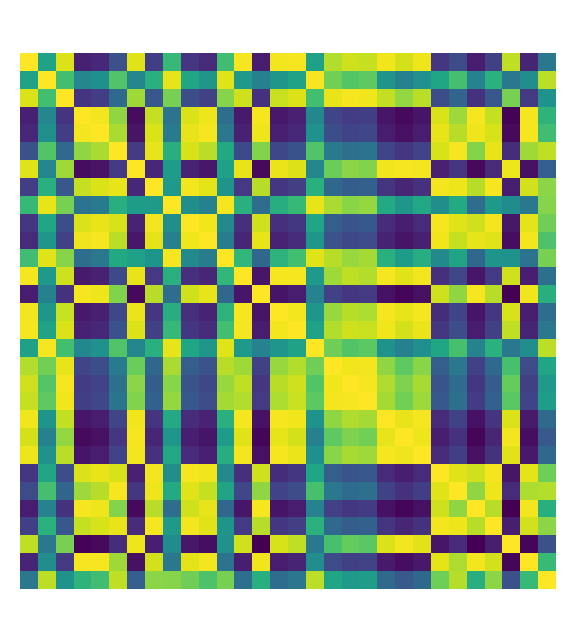

In [5]:
# Evaluate kernel matrix
Khat = kernel.matrix(X[0:30])

# Plot kernel matrix
with plt.rc_context(bundles.beamer_moml(rel_width=0.5, rel_height=1.0)):
    plt.imshow(Khat)
    plt.axis("off")
    plt.axis("equal")
    plt.show()

**Task:** Plot the condition number of the kernel matrix $K = k(X, X)$ for the kernels Matern($1/2$), Matern($3/2$) and an exponentiated quadratic / RBF kernel for increasing dataset size $n=1$ to $n=1000$. What do you observe?

In [6]:
cond_Khat = {}
for kernel_name, kernel in [
    ("Matern(1/2)", randprocs.kernels.Matern(nu=1 / 2, input_shape=())),
    ("Matern(3/2)", randprocs.kernels.Matern(nu=3 / 2, input_shape=())),
    ("RBF", randprocs.kernels.ExpQuad(input_shape=())),
]:
    kernel_damped = kernel + randprocs.kernels.WhiteNoise(
        input_shape=(), sigma_sq=10**-6
    )
    ns = np.logspace(start=0, stop=3, num=10, base=10, dtype=int)
    cond_Khat[kernel_name] = []
    for n in ns:
        cond_Khat[kernel_name].append(np.linalg.cond(kernel.matrix(X[0 : n + 1])))


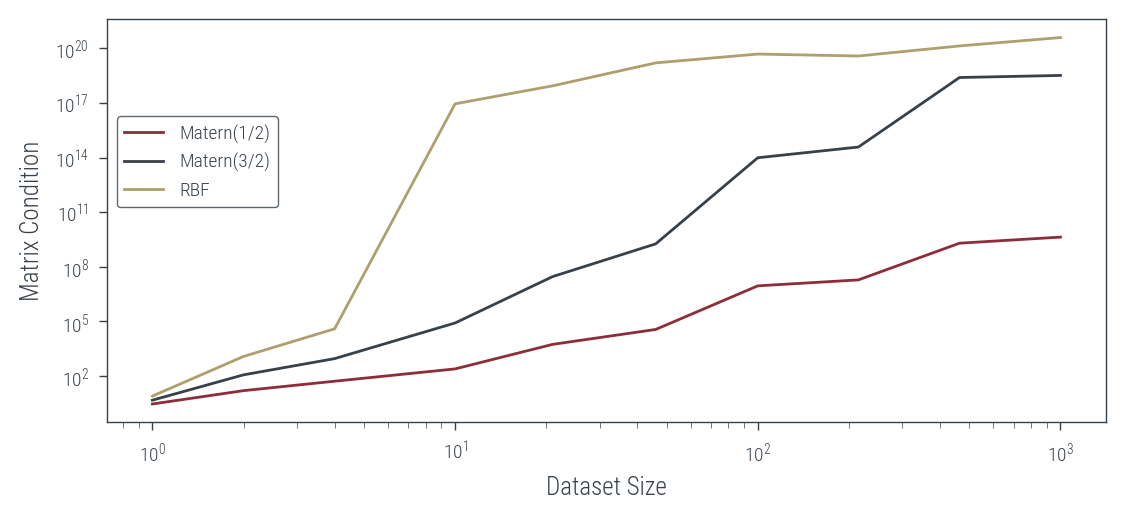

In [7]:
fig, axs = plt.subplots()
for i, kernel_name in enumerate(["Matern(1/2)", "Matern(3/2)", "RBF"]):
    axs.plot(ns, cond_Khat[kernel_name], label=kernel_name)

axs.set(xlabel="Dataset Size", ylabel="Matrix Condition", yscale="log", xscale="log")
fig.legend(borderaxespad=6, loc="upper left")
plt.show()


**Task:** What happens if you consider the damped kernel matrix $\hat{K} = K + \sigma^2 I$ for an observation noise of $\sigma^2=10^{-6}$?

Next, our goal will be to approximately solve the linear system $\hat{K} v = y$, which is needed to approximate the posterior mean of a Gaussian process iteratively. We'll compare the partial Cholesky, the method of conjugate gradients and its preconditioned version with respect to their speed of convergence.

We begin by again generating a synthetic dataset and defining our kernel matrix. Here, we construct a linear operator, which does not fully form the kernel matrix in memory, but only implements the matrix-vector product $w \mapsto \hat{K} w$. This allows us to only use $\mathcal{O(nd)}$ memory.

In [8]:
# Dataset
num_data = 100000
data = itergp.datasets.SyntheticDataset(
    rng_state=rng_state,
    size=(num_data, 1000),
    input_shape=input_shape,
    output_shape=output_shape,
    noise_var=0.1,
    fun= fun
)
X = data.train.X
y = data.train.y

# Model
sigma_sq = 0.1
kernel = randprocs.kernels.Matern(nu=1.5, input_shape=()) 

# Lazily evaluated kernel matrix
K = itergp.linops.KernelMatrix(kernel=kernel, x0=X)
Khat = K + linops.Scaling(factors=sigma_sq, shape=K.shape)


**Task:** Compute a matrix-vector product $w \mapsto \hat{K}w$ with the (damped) kernel matrix for a dataset of size $n=10^6$. Linear operators support the same Python syntax `A @ b` for matrix-vector multiplication as NumPy arrays.

In [9]:
Kv = Khat @ np.ones(shape=(100000))

In [10]:
Kv.shape

(100000,)

We will now solve a linear system with the kernel matrix with the partial Cholesky, CG and preconditioned CG. For quick debugging reduce the size of the dataset depending on your hardware.

We begin by setting up the linear system and the solver configuration.

In [11]:
from probnum.linalg import solvers

# Linear system
problem = problems.LinearSystem(Khat, y)

# Solver setup
P = linops.Zero(shape=(X.shape[0], X.shape[0]))
Pinv = linops.Zero(shape=(X.shape[0], X.shape[0]))
linsys_prior = solvers.beliefs.LinearSystemBelief(
    x=randvars.Normal(mean=Pinv @ problem.b, cov=Khat.inv()),
    Ainv=Pinv,
    A=P,
)

Next, we construct a partial Cholesky preconditioner $\hat{P}_k = L_k L_k^\top + \sigma^2 I \approx \hat{K}$.

**Question:** What is the rank $k$ of the low-rank component of $\hat{P}_k$ in this case?

In [12]:
from itergp.methods import ConjugateGradient, Cholesky, preconditioners

# Partial Cholesky preconditioner
qoi_belief, _ = Cholesky(maxrank=20).solve(
    linsys_prior, problems.LinearSystem(K, y)
)

precond = preconditioners.DiagonalPlusLowRank(
    diagonal=sigma_sq,
    low_rank_factor=K @ qoi_belief.Ainv._summands[1].U,
)


Now, we can define our linear solvers.

In [13]:
# Linear solvers
maxiter = 100

cholesky = Cholesky(maxrank=maxiter)

cg = ConjugateGradient(
    precond_inv=None,
    maxiter=maxiter,
    atol=1e-12,
    rtol=1e-12,
    reorthogonalization_fn_residual=None,
)

precond_cg = ConjugateGradient(
    precond_inv=precond.inv(),
    maxiter=maxiter,
    atol=1e-12,
    rtol=1e-12,
    reorthogonalization_fn_residual=None,
)


**Task**: Solve the linear system $\hat{K} v = y$ with Cholesky, CG and preconditioned CG and plot the norm of the residual $r_i = y - \hat{K}v_i$ given by $\lVert r_i \rVert_2 = \lVert \hat{K} (v - v_i) \rVert_2 = \lVert v - v_i \rVert_{\hat{K}^\top \hat{K}}$.

Note, that in the lecture we plotted the error in $\hat{K}$-norm, i.e. $\lVert v - v_i \rVert_{\hat{K}}$, to understand the convergence of CG. However, this requires us to know the true solution $v$. So instead as a proxy we can track the residual norm, for which we do not need access to $v$.

In [14]:
# Linear solves
_, solver_state_cholesky = cholesky.solve(problem=problem, prior=linsys_prior)
_, solver_state_cg = cg.solve(problem=problem, prior=linsys_prior)
_, solver_state_precond_cg = precond_cg.solve(problem=problem, prior=linsys_prior)

# On desktop machine with i7 CPU and 32gb RAM: 16m to do all three solves for n = 100,000

Hint: The linear solvers automatically track the residuals.

In [15]:
# Residuals for all iterations
residuals_cholesky = solver_state_cholesky.residuals[:-1]

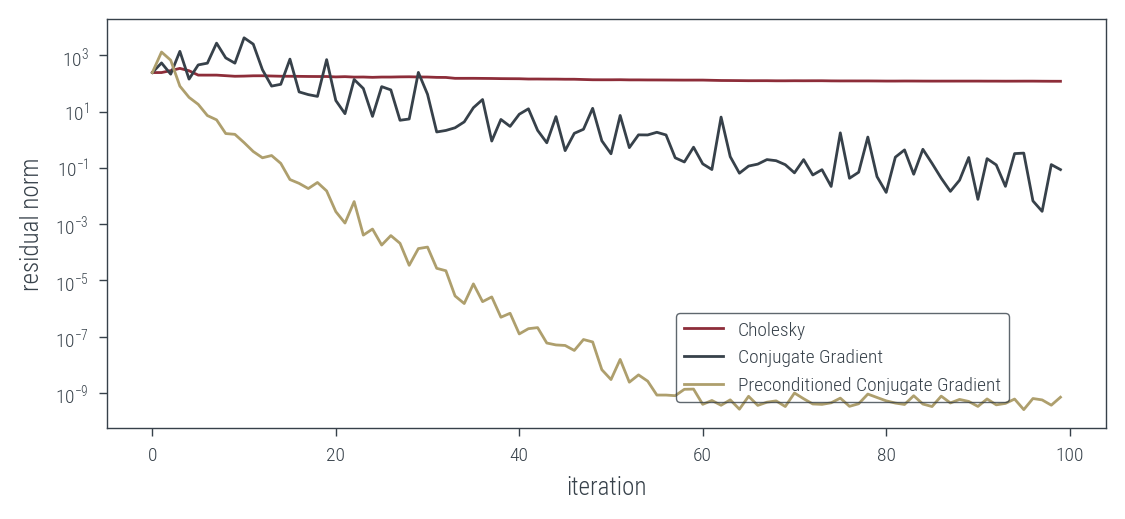

In [16]:
# Plot residual error
fig, ax = plt.subplots()
ax.plot(
    backend.linalg.vector_norm(backend.asarray(solver_state_cholesky.residuals[:-1]), axis=1), label="Cholesky"
)
ax.plot(
    backend.linalg.vector_norm(backend.asarray(solver_state_cg.residuals[:-1]), axis=1), label="Conjugate Gradient"
)
ax.plot(
    backend.linalg.vector_norm(backend.asarray(solver_state_precond_cg.residuals[:-1]), axis=1), label="Preconditioned Conjugate Gradient"
)
ax.set(
    xlabel="iteration",
    ylabel="residual norm",
    yscale="log",
    xscale="linear",
)
fig.legend(loc="lower right", borderaxespad=6)
plt.show()

**Question:** What happens if you vary the size of the preconditioner?

## GP Hyperparameter Optimization via Iterative Methods

We will now perform full Gaussian process inference including hyperparameter optimization using GPyTorch, a GP library with a PyTorch backend. It heavily relies on the method of conjugate gradients and implements the stochastic estimation of the trace based on matrix-vector multiplication that was described in the lecture.

**Task:** Begin by installing GPyTorch (e.g. `pip install gpytorch`).

In [17]:
import torch
import gpytorch
torch.set_default_dtype(torch.double)

We will again generate a synthetic dataset for experimentation purposes. Feel free to change the dataset size to whatever allows quick experimentation on your hardware.

In [18]:
# Generate data
rng_state = backend.random.rng_state(42)

num_data = 2000
input_shape = ()
output_shape = ()

rng_state, rng_state_data = backend.random.split(rng_state, num=2)
fun = lambda x: np.arctan(2 * np.pi * x) + x * np.sin(8 * np.pi * x)
data = itergp.datasets.SyntheticDataset(
    rng_state=rng_state,
    size=(num_data, 1000),
    input_shape=input_shape,
    output_shape=output_shape,
    noise_var=0.1,
    fun= fun
)

X = torch.as_tensor(data.train.X)
y = torch.as_tensor(data.train.y)
X_test = torch.as_tensor(data.test.X)
y_test = torch.as_tensor(data.test.y)

Next, we set up the Gaussian process model. 

**Task:** Define the GP model with a scaled Matern($5/2$) kernel and initialize the kernel hyperparameters like so:
- outputscale: 3.0
- lengthscale: 1.0
- noise $\sigma^2$: 0.01

What modeling assumptions do these hyperparameters encode, i.e. what is their interpretation?

In [19]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


hyperparams = {
    "covar_module.outputscale": torch.tensor(3.0),
    "covar_module.base_kernel.lengthscale": torch.tensor(1.0),
    "likelihood.noise_covar.noise": torch.tensor(10**-2),
}

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X, y, likelihood)
model.initialize(**hyperparams)

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

Now let's optimize the hyperparameters with respect to the log-marginal likelihood. We choose Adam as our optimizer here, but other choices (like L-BFGS or SGD) also work.

In [20]:
model.train()
likelihood.train()
training_iter = 20

# Choice of optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# (Negative) loss function
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

loss_vals = []
for i in range(training_iter):
    optimizer.zero_grad()

    # Predict on training data
    output = model(X)

    # Evaluate loss
    loss = -mll(output, y)

    # Compute gradient
    loss.backward()

    loss_vals.append(loss.item())
    print('Iter %d/%d - Loss: %.3f  outputscale: %.3f  lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.outputscale.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))

    # Update hyperparameters
    optimizer.step()

Iter 1/20 - Loss: 8.294  outputscale: 3.000  lengthscale: 1.000   noise: 0.010
Iter 2/20 - Loss: 7.170  outputscale: 3.095  lengthscale: 0.938   noise: 0.011
Iter 3/20 - Loss: 6.157  outputscale: 3.191  lengthscale: 0.878   noise: 0.012
Iter 4/20 - Loss: 5.251  outputscale: 3.287  lengthscale: 0.821   noise: 0.013
Iter 5/20 - Loss: 4.449  outputscale: 3.382  lengthscale: 0.766   noise: 0.015
Iter 6/20 - Loss: 3.748  outputscale: 3.477  lengthscale: 0.714   noise: 0.016
Iter 7/20 - Loss: 3.145  outputscale: 3.572  lengthscale: 0.665   noise: 0.018
Iter 8/20 - Loss: 2.634  outputscale: 3.664  lengthscale: 0.618   noise: 0.019
Iter 9/20 - Loss: 2.210  outputscale: 3.755  lengthscale: 0.575   noise: 0.021
Iter 10/20 - Loss: 1.861  outputscale: 3.843  lengthscale: 0.535   noise: 0.023
Iter 11/20 - Loss: 1.581  outputscale: 3.927  lengthscale: 0.498   noise: 0.025
Iter 12/20 - Loss: 1.357  outputscale: 4.007  lengthscale: 0.465   noise: 0.027
Iter 13/20 - Loss: 1.178  outputscale: 4.083  len

**Task:** Plot the negative log-marginal likelihood (i.e. the loss) on the training data over time. What are the final values for the outputscale, lengthscale and the noise after 10 optimization steps?

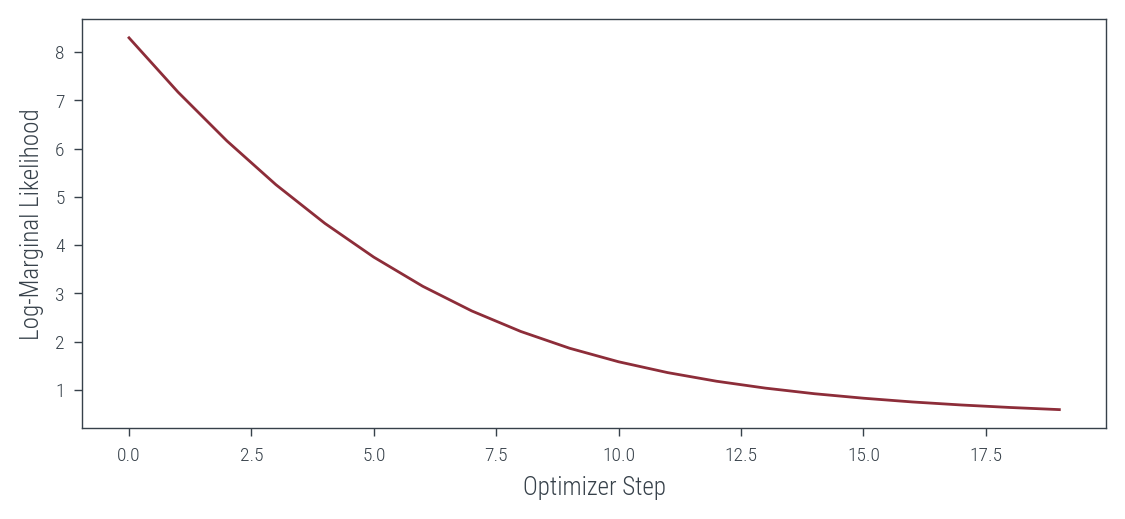

In [21]:
# Plot of negative log-marginal likelihood of the training data
fig, ax = plt.subplots()
ax.plot(loss_vals, color="C0")
ax.set(xlabel="Optimizer Step", ylabel="Log-Marginal Likelihood")
plt.show()

Now let's compute the log-marginal likelihood on the test data and plot the final result.

**Question:** Does the model generalize well? What could we do to improve generalization performance?

In [22]:
model.eval()
likelihood.eval()

with (
    torch.no_grad()
    and gpytorch.settings.fast_computations(
        covar_root_decomposition=True, log_prob=True, solves=True
    )
    and gpytorch.settings.fast_pred_var(True)
):
    xs = torch.as_tensor(data.test.X)
    f_preds = model(xs)
    y_preds = likelihood(f_preds)
    print(f"Log-marginal likelihood of test data: {-mll(f_preds, y_test).item()}")


Log-marginal likelihood of test data: 0.4100046265059998


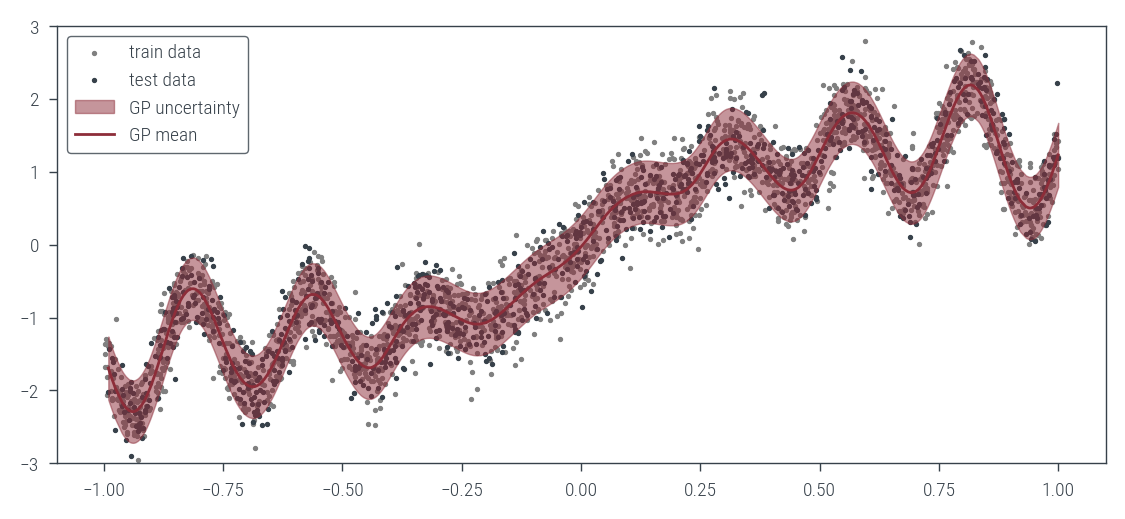

In [23]:
# Plot of data and model

with torch.no_grad():
    fig, ax = plt.subplots()

    idcs = torch.argsort(X_test)
    # Get upper and lower confidence bounds
    lower, upper = y_preds[idcs].confidence_region()
    ax.scatter(X.numpy(), y.numpy(), color="gray", s=2, label="train data")
    ax.scatter(X_test.numpy(), y_test.numpy(), color="C1", s=2, label="test data")
    ax.fill_between(
        X_test[idcs].numpy(), lower.numpy(), upper.numpy(), alpha=0.5, color="C0", label="GP uncertainty"
    )
    ax.plot(X_test[idcs].numpy(), y_preds[idcs].mean.numpy(), label="GP mean")
    ax.set_ylim([-3, 3])
    ax.legend()
    plt.show()